# Tweet Sentiment Analysis and Currency Market Correlation

This notebook analyzes the correlation between Trump's social media sentiment and currency market movements by:
1. Loading tweet data
2. Extracting country mentions and mapping to currencies
3. Analyzing sentiment using NLTK
4. Correlating with exchange rate movements

## 1. Loading Data

Import required libraries and load the tweets dataset.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pycountry
from datetime import datetime, timedelta
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.ndimage import gaussian_filter1d
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

print("Libraries imported successfully")

Libraries imported successfully


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/connor.sullivan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Load the tweets dataset
df = pd.read_csv('tweets.csv', on_bad_lines='skip')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

print(f"Loaded {len(df)} tweets")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print("\nDataset info:")
print(df.info())
print("\nFirst few tweets:")
print(df[['date', 'text']].head())

Loaded 6896 tweets
Date range: 2024-10-13 04:23:37+00:00 to 2025-10-25 22:15:50+00:00

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6896 entries, 0 to 6895
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   page_number            6896 non-null   int64              
 1   browse_flag            6896 non-null   bool               
 2   date                   6896 non-null   datetime64[ns, UTC]
 3   document_id            6896 non-null   int64              
 4   image_url              6896 non-null   object             
 5   media_type             6896 non-null   object             
 6   sequence               6896 non-null   int64              
 7   speaker                6896 non-null   object             
 8   speaker_id             6896 non-null   object             
 9   subject                6896 non-null   object             
 10  text               

## 2. Adding Country and Currency Columns

Extract country mentions from tweets and map them to their respective currencies.

In [3]:
def find_countries_regex(text):
    """Extract country names from text using regex patterns"""
    if pd.isna(text):
        return []

    # Common country name patterns
    country_patterns = [
        r'\b(?:United States|USA|US|America|American)\b',
        r'\bCanada\b|\bCanadian\b',
        r'\bChina\b|\bChinese\b',
        r'\bJapan\b|\bJapanese\b',
        r'\b(?:United Kingdom|UK|Britain|British|England|English)\b',
        r'\bGermany\b|\bGerman\b',
        r'\bFrance\b|\bFrench\b',
        r'\bItaly\b|\bItalian\b',
        r'\bSpain\b|\bSpanish\b',
        r'\bIndia\b|\bIndian\b',
        r'\bBrazil\b|\bBrazilian\b',
        r'\bMexico\b|\bMexican\b',
        r'\bRussia\b|\bRussian\b',
        r'\bSouth Korea\b|\bKorea\b|\bKorean\b',
        r'\bAustralia\b|\bAustralian\b',
        r'\bSwitzerland\b|\bSwiss\b',
        r'\bNorway\b|\bNorwegian\b',
        r'\bSweden\b|\bSwedish\b',
        r'\bDenmark\b|\bDanish\b',
        r'\bNetherlands\b|\bDutch\b'
    ]

    countries = set()
    text_upper = text.upper()

    for pattern in country_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        for match in matches:
            # Normalize country names
            if re.match(r'(?i)united states|usa|us|america|american', match):
                countries.add('United States')
            elif re.match(r'(?i)canada|canadian', match):
                countries.add('Canada')
            elif re.match(r'(?i)china|chinese', match):
                countries.add('China')
            elif re.match(r'(?i)japan|japanese', match):
                countries.add('Japan')
            elif re.match(r'(?i)united kingdom|uk|britain|british|england|english', match):
                countries.add('United Kingdom')
            elif re.match(r'(?i)germany|german', match):
                countries.add('Germany')
            elif re.match(r'(?i)france|french', match):
                countries.add('France')
            elif re.match(r'(?i)italy|italian', match):
                countries.add('Italy')
            elif re.match(r'(?i)spain|spanish', match):
                countries.add('Spain')
            elif re.match(r'(?i)india|indian', match):
                countries.add('India')
            elif re.match(r'(?i)brazil|brazilian', match):
                countries.add('Brazil')
            elif re.match(r'(?i)mexico|mexican', match):
                countries.add('Mexico')
            elif re.match(r'(?i)russia|russian', match):
                countries.add('Russia')
            elif re.match(r'(?i)south korea|korea|korean', match):
                countries.add('South Korea')
            elif re.match(r'(?i)australia|australian', match):
                countries.add('Australia')
            elif re.match(r'(?i)switzerland|swiss', match):
                countries.add('Switzerland')
            elif re.match(r'(?i)norway|norwegian', match):
                countries.add('Norway')
            elif re.match(r'(?i)sweden|swedish', match):
                countries.add('Sweden')
            elif re.match(r'(?i)denmark|danish', match):
                countries.add('Denmark')
            elif re.match(r'(?i)netherlands|dutch', match):
                countries.add('Netherlands')

    return list(countries)

# Extract countries from tweets
df['countries_found'] = df['text'].apply(find_countries_regex)
df['countries_mentioned'] = df['countries_found'].apply(lambda x: ', '.join(x) if x else '')

# Filter tweets with country mentions
tweets_with_countries = df[df['countries_mentioned'] != ''].copy()

print(f"Found {len(tweets_with_countries)} tweets with country mentions out of {len(df)} total tweets")
print(f"Percentage with countries: {len(tweets_with_countries)/len(df)*100:.1f}%")

# Show country mention frequency
all_countries = []
for countries in tweets_with_countries['countries_found']:
    all_countries.extend(countries)

country_counts = pd.Series(all_countries).value_counts()
print("\nTop 10 mentioned countries:")
print(country_counts.head(10))

Found 1949 tweets with country mentions out of 6896 total tweets
Percentage with countries: 28.3%

Top 10 mentioned countries:
United States     1751
Russia             128
China               98
Canada              55
Mexico              44
United Kingdom      33
India               26
Japan               21
France              12
South Korea         10
Name: count, dtype: int64


In [4]:
def country_to_currency(country_name):
    """Map country names to their currency codes"""
    # Manual mapping for common countries
    country_currency_map = {
        'United States': 'USD',
        'Canada': 'CAD',
        'United Kingdom': 'GBP',
        'Japan': 'JPY',
        'Germany': 'EUR',
        'France': 'EUR',
        'Italy': 'EUR',
        'Spain': 'EUR',
        'Netherlands': 'EUR',
        'China': 'CNY',
        'India': 'INR',
        'Brazil': 'BRL',
        'Mexico': 'MXN',
        'Russia': 'RUB',
        'South Korea': 'KRW',
        'Australia': 'AUD',
        'Switzerland': 'CHF',
        'Norway': 'NOK',
        'Sweden': 'SEK',
        'Denmark': 'DKK'
    }

    if country_name in country_currency_map:
        return country_currency_map[country_name]

    # Try pycountry for other countries
    try:
        country = pycountry.countries.search_fuzzy(country_name)[0]
        currency = pycountry.currencies.get(numeric=country.numeric)
        if currency:
            return currency.alpha_3
    except:
        pass

    return None

# Map countries to currencies
tweets_with_countries['currencies'] = tweets_with_countries['countries_found'].apply(
    lambda countries: [country_to_currency(country) for country in countries if country_to_currency(country)]
)

tweets_with_countries['currency_codes'] = tweets_with_countries['currencies'].apply(
    lambda x: ', '.join(set(x)) if x else ''
)

# Add currencies_found to the main dataframe
df['currencies_found'] = df['countries_found'].apply(
    lambda countries: [country_to_currency(country) for country in countries if country_to_currency(country)]
)

# Add currency_codes to the main dataframe
df['currency_codes'] = df['currencies_found'].apply(
    lambda x: ', '.join(set(x)) if x else ''
)

# Filter tweets with valid currency mappings
tweets_with_currencies = tweets_with_countries[tweets_with_countries['currency_codes'] != ''].copy()

print(f"Successfully mapped {len(tweets_with_currencies)} tweets to currencies")

# Show currency mention frequency
all_currencies = []
for currencies in tweets_with_currencies['currencies']:
    all_currencies.extend(currencies)

currency_counts = pd.Series(all_currencies).value_counts()
print("\nCurrency mention frequency:")
print(currency_counts.head(15))

Successfully mapped 1949 tweets to currencies

Currency mention frequency:
USD    1751
RUB     128
CNY      98
CAD      55
MXN      44
EUR      33
GBP      33
INR      26
JPY      21
KRW      10
BRL       5
AUD       4
SEK       3
CHF       2
NOK       1
Name: count, dtype: int64


## 3. Adding Sentiment Columns

Analyze the sentiment of each tweet using NLTK's VADER sentiment analyzer.

In [5]:
def get_sentiment_scores(text):
    """Get sentiment scores for a given text using VADER"""
    analyzer = SentimentIntensityAnalyzer()

    if pd.isna(text):
        return {
            'sentiment_compound': 0.0,
            'sentiment_positive': 0.0,
            'sentiment_negative': 0.0,
            'sentiment_neutral': 0.0
        }

    scores = analyzer.polarity_scores(text)
    return {
        'sentiment_compound': scores['compound'],  # Overall sentiment (-1 to 1)
        'sentiment_positive': scores['pos'],       # Positive sentiment ratio
        'sentiment_negative': scores['neg'],       # Negative sentiment ratio
        'sentiment_neutral': scores['neu']         # Neutral sentiment ratio
    }

def categorize_sentiment(compound_score):
    """Categorize sentiment based on compound score"""
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to all tweets
print("Analyzing sentiment for all tweets...")
sentiment_results = df['text'].apply(get_sentiment_scores)

# Extract sentiment scores into separate columns
df['sentiment_compound'] = sentiment_results.apply(lambda x: x['sentiment_compound'])
df['sentiment_positive'] = sentiment_results.apply(lambda x: x['sentiment_positive'])
df['sentiment_negative'] = sentiment_results.apply(lambda x: x['sentiment_negative'])
df['sentiment_neutral'] = sentiment_results.apply(lambda x: x['sentiment_neutral'])

# Add categorical sentiment label
df['sentiment_label'] = df['sentiment_compound'].apply(categorize_sentiment)

print("Sentiment analysis complete!")
print(f"\nSentiment distribution:")
print(df['sentiment_label'].value_counts())
print(f"\nAverage compound sentiment: {df['sentiment_compound'].mean():.3f}")
print(f"Sentiment range: {df['sentiment_compound'].min():.3f} to {df['sentiment_compound'].max():.3f}")

# Show sample tweets with sentiment
print("\nSample tweets with sentiment scores:")
sample_df = df[['text', 'sentiment_compound', 'sentiment_label']].head(10)
for idx, row in sample_df.iterrows():
    print(f"\nTweet: {row['text'][:100]}...")
    print(f"Compound Score: {row['sentiment_compound']:.3f} ({row['sentiment_label']})")

Analyzing sentiment for all tweets...
Sentiment analysis complete!

Sentiment distribution:
sentiment_label
neutral     3507
positive    2430
negative     959
Name: count, dtype: int64

Average compound sentiment: 0.177
Sentiment range: -0.998 to 0.997

Sample tweets with sentiment scores:

Tweet: I am on my way to Malaysia, where I will sign the great Peace Deal, which I proudly brokered between...
Compound Score: 0.968 (positive)

Tweet: RT @realDonaldTrump Canada was caught, red handed, putting up a fraudulent advertisement on Ronald R...
Compound Score: -0.893 (negative)

Tweet: https://www. dailysignal.com/2025/10/22/tru mps-middle-east-triumph-embarrassed-self-proclaimed-expe...
Compound Score: 0.000 (neutral)

Tweet: https://www. foxnews.com/opinion/new-high-t ech-tool-trump-using-secure-our-border...
Compound Score: 0.000 (neutral)

Tweet: https://www. foxnews.com/politics/scoop-tru mps-memphis-crime-crackdown-locates-dozens-missing-kids-...
Compound Score: 0.000 (neutral)

Twe

In [6]:
# Reorder columns in the dataframe for better organization
print("Current column order:")
print(list(df.columns))

# Define the desired column order
new_column_order = []

# First column: tweet ID (use index if no id column exists)
if 'id' in df.columns:
    new_column_order.append('id')
else:
    # Add the index as the first column (tweet ID)
    df = df.reset_index()
    df = df.rename(columns={'index': 'tweet_id'})
    new_column_order.append('tweet_id')

# Next three columns: date, text, image_url
priority_columns = ['date', 'text', 'image_url']
for col in priority_columns:
    if col in df.columns:
        new_column_order.append(col)

# Next: country and currency columns
country_currency_columns = ['countries_found', 'currencies_found']
for col in country_currency_columns:
    if col in df.columns:
        new_column_order.append(col)

# Then: sentiment columns
sentiment_columns = ['sentiment_compound', 'sentiment_positive', 'sentiment_negative', 'sentiment_neutral', 'sentiment_label']
for col in sentiment_columns:
    if col in df.columns:
        new_column_order.append(col)

# Finally: all remaining columns (exclude already added columns)
remaining_columns = [col for col in df.columns if col not in new_column_order]
new_column_order.extend(remaining_columns)

# Reorder the dataframe
df_reordered = df[new_column_order]

print(f"\nNew column order:")
print(list(df_reordered.columns))

# Save to new CSV file
output_filename = 'tweets_reordered.csv'
df_reordered.to_csv(output_filename, index=False)

print(f"\nReordered dataframe saved to {output_filename}")
print(f"Shape: {df_reordered.shape}")
print(f"\nFirst few rows of reordered data:")
id_col = 'id' if 'id' in df_reordered.columns else 'tweet_id'
print(df_reordered.head()[[id_col, 'date', 'text', 'image_url', 'countries_mentioned', 'sentiment_compound', 'sentiment_label']])

Current column order:
['page_number', 'browse_flag', 'date', 'document_id', 'image_url', 'media_type', 'sequence', 'speaker', 'speaker_id', 'subject', 'text', 'type', 'word_count', 'deleted_flag', 'account_url', 'handle', 'id', 'platform', 'post_url', 'social_author', 'social_favorite_count', 'social_repost_count', 'social_visibility', 'search_id', 'score', 'countries_found', 'countries_mentioned', 'currencies_found', 'currency_codes', 'sentiment_compound', 'sentiment_positive', 'sentiment_negative', 'sentiment_neutral', 'sentiment_label']

New column order:
['id', 'date', 'text', 'image_url', 'countries_found', 'currencies_found', 'sentiment_compound', 'sentiment_positive', 'sentiment_negative', 'sentiment_neutral', 'sentiment_label', 'page_number', 'browse_flag', 'document_id', 'media_type', 'sequence', 'speaker', 'speaker_id', 'subject', 'type', 'word_count', 'deleted_flag', 'account_url', 'handle', 'platform', 'post_url', 'social_author', 'social_favorite_count', 'social_repost_cou

In [ ]:
# Analysis: Single vs Multiple Non-USA Country Mentions
print("=== SINGLE vs MULTIPLE NON-USA COUNTRY MENTIONS ANALYSIS ===\n")

# Filter tweets that mention countries
tweets_with_countries = df[df['countries_found'].apply(lambda x: len(x) > 0 if x else False)].copy()

print(f"Total tweets with country mentions: {len(tweets_with_countries)}")
print(f"Total tweets analyzed: {len(df)}")
print(f"Percentage with country mentions: {len(tweets_with_countries)/len(df)*100:.1f}%\n")

# Separate USA and non-USA countries for each tweet
def analyze_country_mentions(countries_list):
    """Analyze country mentions to separate USA from non-USA countries"""
    if not countries_list:
        return {
            'total_countries': 0,
            'has_usa': False,
            'non_usa_countries': [],
            'non_usa_count': 0
        }

    non_usa_countries = [country for country in countries_list if country != 'United States']

    return {
        'total_countries': len(countries_list),
        'has_usa': 'United States' in countries_list,
        'non_usa_countries': non_usa_countries,
        'non_usa_count': len(non_usa_countries)
    }

# Apply analysis to tweets with countries
tweets_with_countries['country_analysis'] = tweets_with_countries['countries_found'].apply(analyze_country_mentions)

# Extract specific metrics
tweets_with_countries['has_usa'] = tweets_with_countries['country_analysis'].apply(lambda x: x['has_usa'])
tweets_with_countries['non_usa_count'] = tweets_with_countries['country_analysis'].apply(lambda x: x['non_usa_count'])
tweets_with_countries['non_usa_countries'] = tweets_with_countries['country_analysis'].apply(lambda x: x['non_usa_countries'])

# Filter tweets that mention non-USA countries
tweets_with_non_usa = tweets_with_countries[tweets_with_countries['non_usa_count'] > 0].copy()

print(f"Tweets mentioning non-USA countries: {len(tweets_with_non_usa)}")
print(f"Percentage of all tweets: {len(tweets_with_non_usa)/len(df)*100:.1f}%\n")

# Count single vs multiple non-USA country mentions
single_non_usa = tweets_with_non_usa[tweets_with_non_usa['non_usa_count'] == 1]
multiple_non_usa = tweets_with_non_usa[tweets_with_non_usa['non_usa_count'] > 1]

print("🔸 SINGLE NON-USA COUNTRY MENTIONS:")
print(f"   Count: {len(single_non_usa)}")
print(f"   Percentage of non-USA tweets: {len(single_non_usa)/len(tweets_with_non_usa)*100:.1f}%")
print(f"   Percentage of all tweets: {len(single_non_usa)/len(df)*100:.1f}%\n")

print("🔸 MULTIPLE NON-USA COUNTRY MENTIONS:")
print(f"   Count: {len(multiple_non_usa)}")
print(f"   Percentage of non-USA tweets: {len(multiple_non_usa)/len(tweets_with_non_usa)*100:.1f}%")
print(f"   Percentage of all tweets: {len(multiple_non_usa)/len(df)*100:.1f}%\n")

# Ratio analysis
ratio = len(single_non_usa) / len(multiple_non_usa) if len(multiple_non_usa) > 0 else float('inf')
print(f"📊 RATIO: Single to Multiple = {ratio:.2f} : 1")
print(f"   For every {ratio:.1f} tweets mentioning one non-USA country,")
print(f"   there is 1 tweet mentioning multiple non-USA countries\n")

# Detailed breakdown by number of non-USA countries
print("📈 BREAKDOWN BY NUMBER OF NON-USA COUNTRIES:")
non_usa_counts = tweets_with_non_usa['non_usa_count'].value_counts().sort_index()
for count, freq in non_usa_counts.items():
    percentage = freq/len(tweets_with_non_usa)*100
    print(f"   {count} countries: {freq} tweets ({percentage:.1f}%)")

print(f"\n📋 SUMMARY:")
print(f"   • Single non-USA country mentions: {len(single_non_usa)} tweets")
print(f"   • Multiple non-USA country mentions: {len(multiple_non_usa)} tweets")
print(f"   • Ratio (Single:Multiple): {ratio:.2f}:1")

# Show some examples
if len(multiple_non_usa) > 0:
    print(f"\n🔍 EXAMPLES OF MULTIPLE NON-USA COUNTRY MENTIONS:")
    for i, (idx, row) in enumerate(multiple_non_usa.head(3).iterrows()):
        countries_str = ', '.join(row['non_usa_countries'])
        tweet_text = row['text'][:100] + "..." if len(row['text']) > 100 else row['text']
        print(f"   {i+1}. Countries: {countries_str}")
        print(f"      Tweet: {tweet_text}")
        print()

=== SINGLE vs MULTIPLE NON-USA COUNTRY MENTIONS ANALYSIS ===

Total tweets with country mentions: 1949
Total tweets analyzed: 6896
Percentage with country mentions: 28.3%

Tweets mentioning non-USA countries: 405
Percentage of all tweets: 5.9%

🔸 SINGLE NON-USA COUNTRY MENTIONS:
   Count: 363
   Percentage of non-USA tweets: 89.6%
   Percentage of all tweets: 5.3%

🔸 MULTIPLE NON-USA COUNTRY MENTIONS:
   Count: 42
   Percentage of non-USA tweets: 10.4%
   Percentage of all tweets: 0.6%

📊 RATIO: Single to Multiple = 8.64 : 1
   For every 8.6 tweets mentioning one non-USA country,
   there is 1 tweet mentioning multiple non-USA countries

📈 BREAKDOWN BY NUMBER OF NON-USA COUNTRIES:
   1 countries: 363 tweets (89.6%)
   2 countries: 29 tweets (7.2%)
   3 countries: 10 tweets (2.5%)
   4 countries: 2 tweets (0.5%)
   5 countries: 1 tweets (0.2%)

📋 SUMMARY:
   • Single non-USA country mentions: 363 tweets
   • Multiple non-USA country mentions: 42 tweets
   • Ratio (Single:Multiple): 8.64

📊 SINGLE vs MULTIPLE NON-USA COUNTRY MENTIONS - TABLE SUMMARY

🔸 OVERALL STATISTICS:
                     Category                     Count       % of Non-USA Tweets           Additional Info
        Total Tweets Analyzed                     6,896                    100.0%                          
    Tweets with Any Countries                     1,949                     28.3%                          
Tweets with Non-USA Countries                       405                      5.9%                          
                                                                                                           
       Single Non-USA Country                       363                     89.6%        5.3% of all tweets
   Multiple Non-USA Countries                        42                     10.4%        0.6% of all tweets
                                                                                                           
      Ratio (Single:Multiple)                    8.

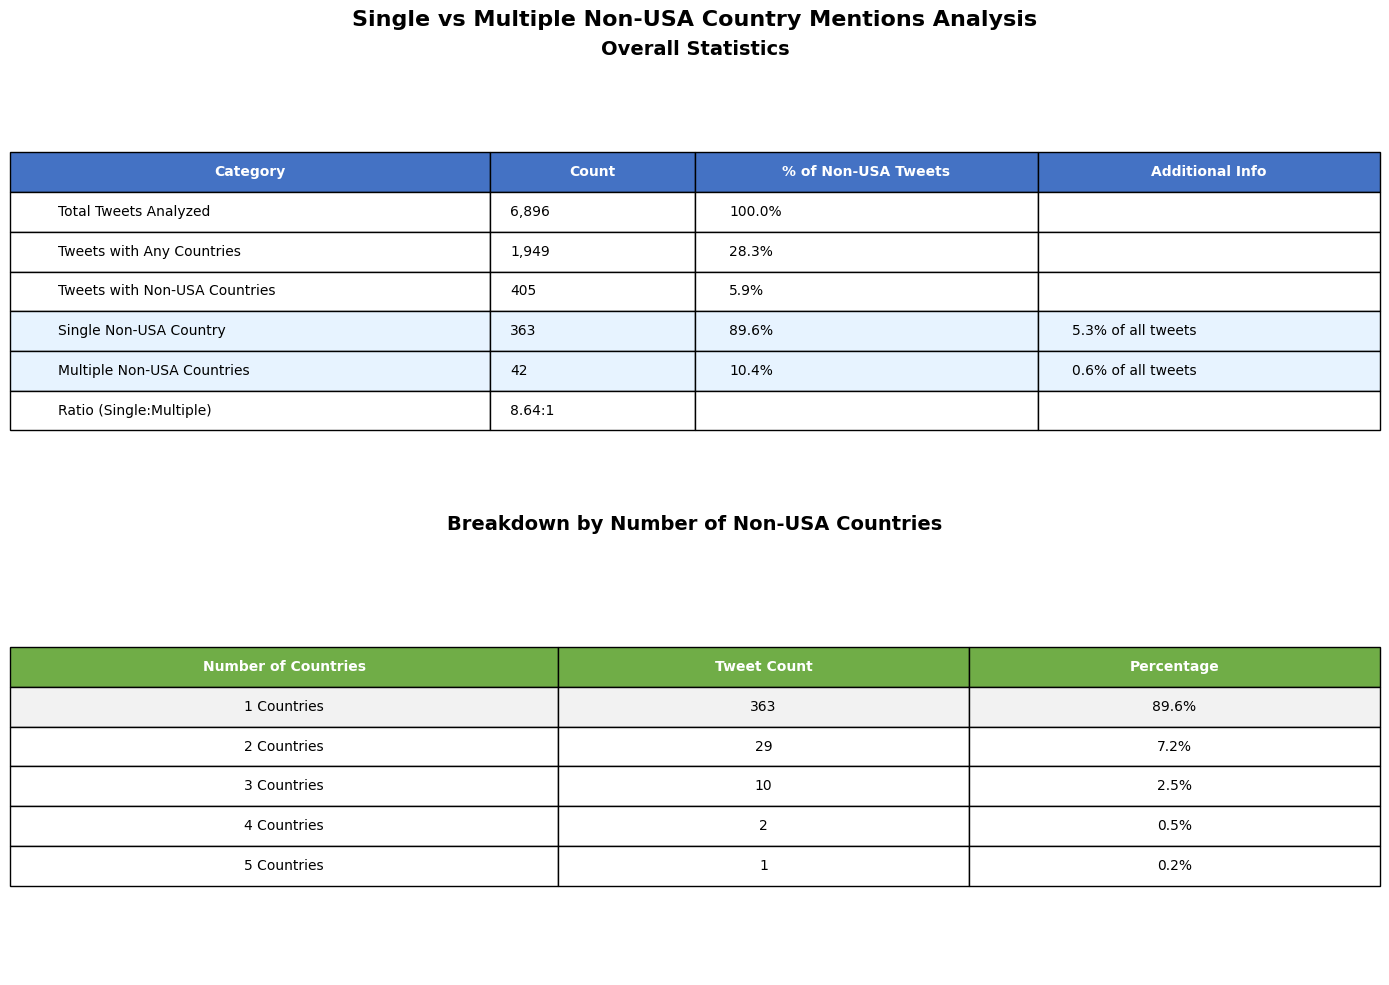


✅ Table chart saved as 'single_vs_multiple_countries_table.png'

📈 KEY INSIGHTS:
   • 363 tweets mention SINGLE non-USA countries (89.6%)
   • 42 tweets mention MULTIPLE non-USA countries (10.4%)
   • Ratio of Single:Multiple = 8.6:1


In [ ]:
# Table Chart: Single vs Multiple Non-USA Country Mentions
import matplotlib.pyplot as plt
import pandas as pd

# Recalculate the data for table display
def analyze_country_mentions(countries_list):
    """Analyze country mentions to separate USA from non-USA countries"""
    if not countries_list:
        return {
            'total_countries': 0,
            'has_usa': False,
            'non_usa_countries': [],
            'non_usa_count': 0
        }

    non_usa_countries = [country for country in countries_list if country != 'United States']

    return {
        'total_countries': len(countries_list),
        'has_usa': 'United States' in countries_list,
        'non_usa_countries': non_usa_countries,
        'non_usa_count': len(non_usa_countries)
    }

# Filter tweets that mention countries
tweets_with_countries = df[df['countries_found'].apply(lambda x: len(x) > 0 if x else False)].copy()

# Apply analysis to tweets with countries
tweets_with_countries['country_analysis'] = tweets_with_countries['countries_found'].apply(analyze_country_mentions)
tweets_with_countries['non_usa_count'] = tweets_with_countries['country_analysis'].apply(lambda x: x['non_usa_count'])
tweets_with_countries['non_usa_countries'] = tweets_with_countries['country_analysis'].apply(lambda x: x['non_usa_countries'])

# Filter tweets that mention non-USA countries
tweets_with_non_usa = tweets_with_countries[tweets_with_countries['non_usa_count'] > 0].copy()

# Count single vs multiple non-USA country mentions
single_non_usa = tweets_with_non_usa[tweets_with_non_usa['non_usa_count'] == 1]
multiple_non_usa = tweets_with_non_usa[tweets_with_non_usa['non_usa_count'] > 1]

# Overall statistics
total_tweets = len(df)
tweets_with_countries_count = len(tweets_with_countries)
tweets_with_non_usa_count = len(tweets_with_non_usa)

# Single vs Multiple breakdown
single_count = len(single_non_usa)
multiple_count = len(multiple_non_usa)
ratio = single_count / multiple_count if multiple_count > 0 else float('inf')

# Create table data
summary_table = pd.DataFrame([
    ['Total Tweets Analyzed', f'{total_tweets:,}', '100.0%', ''],
    ['Tweets with Any Countries', f'{tweets_with_countries_count:,}', f'{tweets_with_countries_count/total_tweets*100:.1f}%', ''],
    ['Tweets with Non-USA Countries', f'{tweets_with_non_usa_count:,}', f'{tweets_with_non_usa_count/total_tweets*100:.1f}%', ''],
    ['', '', '', ''],
    ['Single Non-USA Country', f'{single_count:,}', f'{single_count/tweets_with_non_usa_count*100:.1f}%', f'{single_count/total_tweets*100:.1f}% of all tweets'],
    ['Multiple Non-USA Countries', f'{multiple_count:,}', f'{multiple_count/tweets_with_non_usa_count*100:.1f}%', f'{multiple_count/total_tweets*100:.1f}% of all tweets'],
    ['', '', '', ''],
    ['Ratio (Single:Multiple)', f'{ratio:.2f}:1', '', '']
], columns=['Category', 'Count', '% of Non-USA Tweets', 'Additional Info'])

# Detailed breakdown by number of countries
non_usa_counts = tweets_with_non_usa['non_usa_count'].value_counts().sort_index()
breakdown_data = []
for count, freq in non_usa_counts.items():
    percentage = freq/len(tweets_with_non_usa)*100
    breakdown_data.append([f'{count} Countries', f'{freq:,}', f'{percentage:.1f}%'])

breakdown_table = pd.DataFrame(breakdown_data, columns=['Number of Countries', 'Tweet Count', 'Percentage'])

# Display tables
print("=" * 80)
print("📊 SINGLE vs MULTIPLE NON-USA COUNTRY MENTIONS - TABLE SUMMARY")
print("=" * 80)
print()
print("🔸 OVERALL STATISTICS:")
print(summary_table.to_string(index=False, col_space=25))
print()
print("🔸 DETAILED BREAKDOWN BY NUMBER OF NON-USA COUNTRIES:")
print(breakdown_table.to_string(index=False, col_space=20))

# Create a visual table using matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
fig.suptitle('Single vs Multiple Non-USA Country Mentions Analysis', fontsize=16, fontweight='bold', y=0.98)

# Table 1: Overall Statistics
ax1.axis('tight')
ax1.axis('off')
ax1.set_title('Overall Statistics', fontsize=14, fontweight='bold', pad=10)

# Filter out empty rows for display
display_summary = summary_table[summary_table['Category'] != ''].copy()
table1 = ax1.table(cellText=display_summary.values,
                   colLabels=display_summary.columns,
                   cellLoc='left',
                   loc='center',
                   colWidths=[0.35, 0.15, 0.25, 0.25])

table1.auto_set_font_size(False)
table1.set_fontsize(10)
table1.scale(1, 1.5)

# Style the header
for i in range(len(display_summary.columns)):
    table1[(0, i)].set_facecolor('#4472C4')
    table1[(0, i)].set_text_props(weight='bold', color='white')

# Highlight key rows
highlight_rows = [3, 4]  # Single and Multiple rows (after filtering empty rows)
for row in highlight_rows:
    if row < len(display_summary):
        for col in range(len(display_summary.columns)):
            table1[(row + 1, col)].set_facecolor('#E7F3FF')

# Table 2: Detailed Breakdown
ax2.axis('tight')
ax2.axis('off')
ax2.set_title('Breakdown by Number of Non-USA Countries', fontsize=14, fontweight='bold', pad=10)

table2 = ax2.table(cellText=breakdown_table.values,
                   colLabels=breakdown_table.columns,
                   cellLoc='center',
                   loc='center',
                   colWidths=[0.4, 0.3, 0.3])

table2.auto_set_font_size(False)
table2.set_fontsize(10)
table2.scale(1, 1.5)

# Style the header
for i in range(len(breakdown_table.columns)):
    table2[(0, i)].set_facecolor('#70AD47')
    table2[(0, i)].set_text_props(weight='bold', color='white')

# Highlight the single country row
table2[(1, 0)].set_facecolor('#F2F2F2')
table2[(1, 1)].set_facecolor('#F2F2F2')
table2[(1, 2)].set_facecolor('#F2F2F2')

plt.subplots_adjust(top=0.92, bottom=0.08, hspace=0.3)
plt.savefig('single_vs_multiple_countries_table.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Table chart saved as 'single_vs_multiple_countries_table.png'")
print(f"\n📈 KEY INSIGHTS:")
print(f"   • {single_count:,} tweets mention SINGLE non-USA countries ({single_count/tweets_with_non_usa_count*100:.1f}%)")
print(f"   • {multiple_count:,} tweets mention MULTIPLE non-USA countries ({multiple_count/tweets_with_non_usa_count*100:.1f}%)")
print(f"   • Ratio of Single:Multiple = {ratio:.1f}:1")

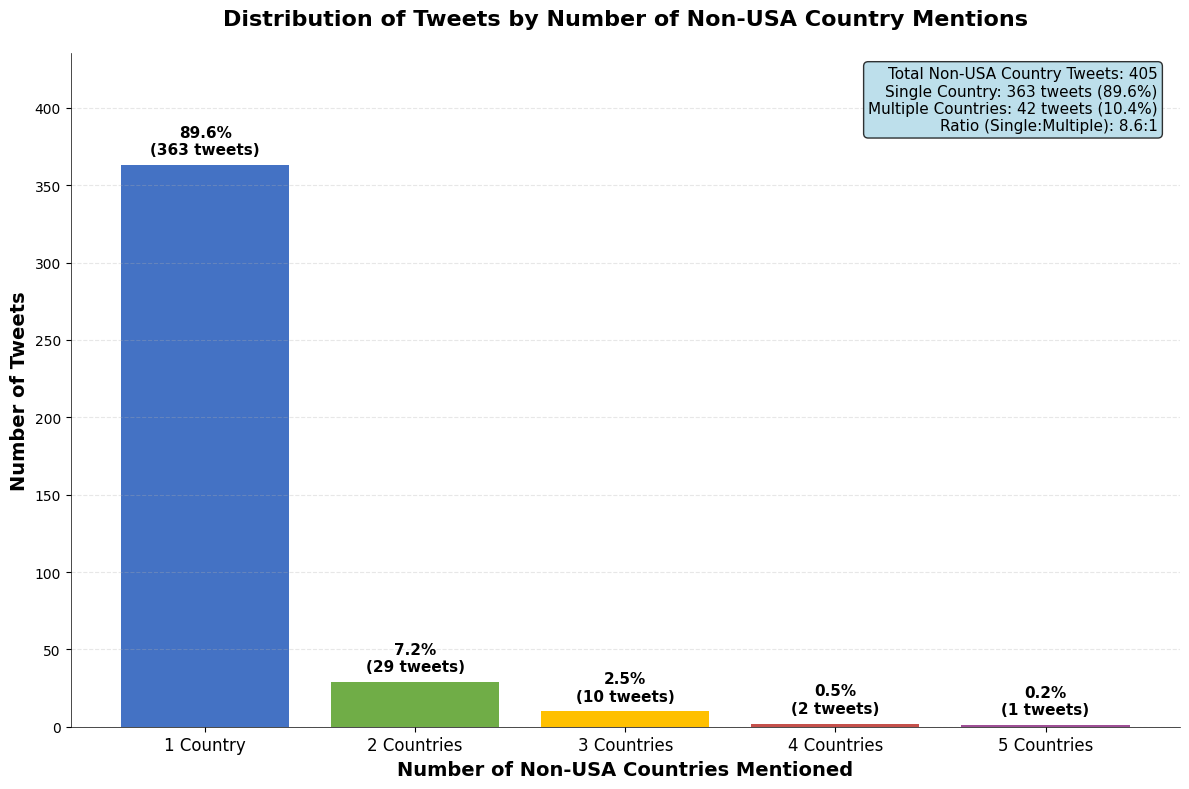

✅ Bar chart saved as 'non_usa_countries_breakdown_bar_chart.png'

📊 BAR CHART INSIGHTS:
   • 1 country mentions dominate with 363 tweets (89.6%)
   • 2 country mentions: 29 tweets (7.2%)
   • Tweets mentioning 3+ countries are rare: 13 tweets (3.2%)


In [11]:
# Bar Chart: Breakdown by Number of Non-USA Countries
import matplotlib.pyplot as plt
import pandas as pd

# Use the same data from the previous analysis
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for bar chart
countries_count = list(non_usa_counts.index)
tweet_counts = list(non_usa_counts.values)
percentages = [count/len(tweets_with_non_usa)*100 for count in tweet_counts]

# Create bar chart
bars = ax.bar(countries_count, tweet_counts, color=['#4472C4', '#70AD47', '#FFC000', '#C5504B', '#9F4F96'])

# Add percentage labels on top of bars
for i, (bar, percentage) in enumerate(zip(bars, percentages)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{percentage:.1f}%\n({height} tweets)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# Customize the chart
ax.set_xlabel('Number of Non-USA Countries Mentioned', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Tweets', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Tweets by Number of Non-USA Country Mentions',
             fontsize=16, fontweight='bold', pad=20)

# Set x-axis labels
ax.set_xticks(countries_count)
ax.set_xticklabels([f'{count} Country' if count == 1 else f'{count} Countries'
                    for count in countries_count], fontsize=12)

# Customize y-axis
ax.set_ylim(0, max(tweet_counts) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add summary statistics as text box
textstr = f'''Total Non-USA Country Tweets: {len(tweets_with_non_usa):,}
Single Country: {single_count:,} tweets ({single_count/tweets_with_non_usa_count*100:.1f}%)
Multiple Countries: {multiple_count:,} tweets ({multiple_count/tweets_with_non_usa_count*100:.1f}%)
Ratio (Single:Multiple): {ratio:.1f}:1'''

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', horizontalalignment='right', bbox=props)

# Style improvements
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

plt.tight_layout()
plt.savefig('non_usa_countries_breakdown_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Bar chart saved as 'non_usa_countries_breakdown_bar_chart.png'")
print(f"\n📊 BAR CHART INSIGHTS:")
print(f"   • {countries_count[0]} country mentions dominate with {tweet_counts[0]:,} tweets ({percentages[0]:.1f}%)")
print(f"   • {countries_count[1]} country mentions: {tweet_counts[1]:,} tweets ({percentages[1]:.1f}%)")
print(f"   • Tweets mentioning 3+ countries are rare: {sum(tweet_counts[2:]):,} tweets ({sum(percentages[2:]):.1f}%)")

📊 SINGLE vs MULTIPLE NON-USA COUNTRY MENTIONS - FOCUSED ANALYSIS

                         Category                  Count    % of Non-USA Tweets     Additional Context
  Single Non-USA Country Mentions                    363                  89.6%    5.26% of all tweets
Multiple Non-USA Country Mentions                     42                  10.4%    0.61% of all tweets
                                                                                                      
             Total Non-USA Tweets                    405                 100.0%     5.9% of all tweets
          Ratio (Single:Multiple)                 8.64:1                                              


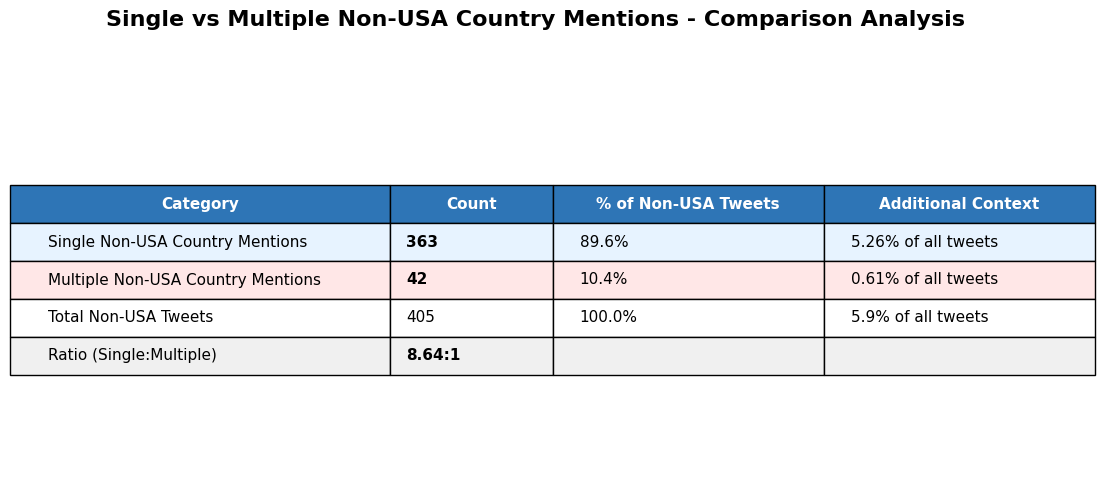


✅ Focused comparison table saved as 'single_vs_multiple_comparison_table.png'

🔍 KEY TAKEAWAYS:
   • Single country mentions are 8.6x more common than multiple mentions
   • 89.6% of non-USA tweets focus on just one country
   • Multiple country discussions represent only 10.4% of non-USA tweets
   • This suggests focused, single-country commentary rather than complex international analysis


In [12]:
# Single vs Multiple Non-USA Country Mentions - Focused Table Chart
import matplotlib.pyplot as plt
import pandas as pd

# Create a focused comparison table for single vs multiple
comparison_data = [
    ['Single Non-USA Country Mentions', f'{single_count:,}', f'{single_count/tweets_with_non_usa_count*100:.1f}%', f'{single_count/total_tweets*100:.2f}% of all tweets'],
    ['Multiple Non-USA Country Mentions', f'{multiple_count:,}', f'{multiple_count/tweets_with_non_usa_count*100:.1f}%', f'{multiple_count/total_tweets*100:.2f}% of all tweets'],
    ['', '', '', ''],
    ['Total Non-USA Tweets', f'{tweets_with_non_usa_count:,}', '100.0%', f'{tweets_with_non_usa_count/total_tweets*100:.1f}% of all tweets'],
    ['Ratio (Single:Multiple)', f'{ratio:.2f}:1', '', '']
]

comparison_table = pd.DataFrame(comparison_data,
                               columns=['Category', 'Count', '% of Non-USA Tweets', 'Additional Context'])

# Display the focused table
print("=" * 90)
print("📊 SINGLE vs MULTIPLE NON-USA COUNTRY MENTIONS - FOCUSED ANALYSIS")
print("=" * 90)
print()
print(comparison_table.to_string(index=False, col_space=22))

# Create a visual focused table using matplotlib
fig, ax = plt.subplots(figsize=(14, 6))
fig.suptitle('Single vs Multiple Non-USA Country Mentions - Comparison Analysis',
             fontsize=16, fontweight='bold', y=0.95)

ax.axis('tight')
ax.axis('off')

# Filter out empty rows for display
display_comparison = comparison_table[comparison_table['Category'] != ''].copy()

# Create the table
table = ax.table(cellText=display_comparison.values,
                colLabels=display_comparison.columns,
                cellLoc='left',
                loc='center',
                colWidths=[0.35, 0.15, 0.25, 0.25])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style the header
for i in range(len(display_comparison.columns)):
    table[(0, i)].set_facecolor('#2E75B6')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight the main comparison rows (Single and Multiple)
table[(1, 0)].set_facecolor('#E7F3FF')  # Single row
table[(1, 1)].set_facecolor('#E7F3FF')
table[(1, 2)].set_facecolor('#E7F3FF')
table[(1, 3)].set_facecolor('#E7F3FF')

table[(2, 0)].set_facecolor('#FFE7E7')  # Multiple row
table[(2, 1)].set_facecolor('#FFE7E7')
table[(2, 2)].set_facecolor('#FFE7E7')
table[(2, 3)].set_facecolor('#FFE7E7')

# Highlight the ratio row
table[(4, 0)].set_facecolor('#F0F0F0')
table[(4, 1)].set_facecolor('#F0F0F0')
table[(4, 2)].set_facecolor('#F0F0F0')
table[(4, 3)].set_facecolor('#F0F0F0')

# Make key numbers bold
table[(1, 1)].set_text_props(weight='bold')  # Single count
table[(2, 1)].set_text_props(weight='bold')  # Multiple count
table[(4, 1)].set_text_props(weight='bold')  # Ratio

plt.subplots_adjust(top=0.85, bottom=0.15)
plt.savefig('single_vs_multiple_comparison_table.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Focused comparison table saved as 'single_vs_multiple_comparison_table.png'")
print(f"\n🔍 KEY TAKEAWAYS:")
print(f"   • Single country mentions are {ratio:.1f}x more common than multiple mentions")
print(f"   • {single_count/tweets_with_non_usa_count*100:.1f}% of non-USA tweets focus on just one country")
print(f"   • Multiple country discussions represent only {multiple_count/tweets_with_non_usa_count*100:.1f}% of non-USA tweets")
print(f"   • This suggests focused, single-country commentary rather than complex international analysis")